**Import Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
torch.cuda.empty_cache
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torchsummary import summary

**Set device (GPU or CPU)**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'GPU device name: {torch.cuda.get_device_name()}')

GPU device name: Tesla P100-PCIE-16GB


**Download dataset and clean files**

In [ ]:
!wget -nc -q 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
!unzip -n -q ml-100k.zip -d '/content'
!rm -rf '/content/ml-100k.zip' 'sample_data'

**Load and count data**

In [ ]:
user_cols = ['User ID', 'Age', 'Sex', 'Occupation', 'ZIP Code']
users = pd.read_csv('/content/ml-100k/u.user', sep='|', names=user_cols, encoding='latin-1')

rating_cols = ['User ID', 'Movie ID', 'Rating', 'Timestamp']
ratings = pd.read_csv('/content/ml-100k/u.data', sep='\t', names=rating_cols,encoding='latin-1')

nb_users = users['User ID'].nunique()
nb_movies = ratings['Movie ID'].nunique()

print(f'Unique # of users ----> {nb_users}')
print(f'Unique # of movies ---> {nb_movies}')

Unique # of users ----> 943
Unique # of movies ---> 1682


**Create data to input into model**

In [ ]:
ratings_matrix = ratings.pivot_table(index=['User ID'], columns=['Movie ID'], values='Rating').reset_index(drop=True)
ratings_matrix.fillna(0, inplace=True)

data_matrix = np.array(ratings_matrix)
print(data_matrix.shape)
print(data_matrix)

(943, 1682)
[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


**Sneak peak -> Users data**

In [ ]:
users.head()

,User ID,Age,Sex,Occupation,ZIP Code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


**Sneak peak -> Ratings data**

In [ ]:
ratings.head()

,User ID,Movie ID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


**Sneak peak -> Items data**

In [ ]:
column_names2 = ['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown',
                 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
                 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
                 'War', 'Western']
items_dataset = pd.read_csv('/content/ml-100k/u.item', sep='|', header=None, names=column_names2, encoding='latin-1')
items_dataset.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**Sneak peak -> Movie data**

In [ ]:
movie_dataset = items_dataset[['movie id', 'movie title']]
movie_dataset.head()

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


**Sneak peak -> movie data part 2**

In [ ]:
m_cols = ['Movie_ID', 'Title', 'Release_Date', 'Video_Release_Date', 'IMDB_URL']
movies = pd.read_csv('/content/ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),encoding='latin-1')
movies.head(10)

,Movie_ID,Title,Release_Date,Video_Release_Date,IMDB_URL
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995)
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...


**Prepping input data**

In [ ]:
data_matrix_torch = torch.FloatTensor(data_matrix).to(device)

**Stacked Autoencoder model**

In [ ]:
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 10)
        self.fc4 = nn.Linear(10, 30)
        self.fc5 = nn.Linear(30, 50)
        self.fc6 = nn.Linear(50, nb_movies)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.fc6(x)
        return x
    
    def prediction(self, x):
        pred = self.forward(x)
        return pred.detach().numpy()
    
model = SAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01, weight_decay=0.5)

**Model Summary**

In [ ]:
summary(model, (943, 1682))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 943, 50]          84,150
           Sigmoid-2              [-1, 943, 50]               0
            Linear-3              [-1, 943, 30]           1,530
           Sigmoid-4              [-1, 943, 30]               0
            Linear-5              [-1, 943, 10]             310
           Sigmoid-6              [-1, 943, 10]               0
            Linear-7              [-1, 943, 30]             330
           Sigmoid-8              [-1, 943, 30]               0
            Linear-9              [-1, 943, 50]           1,550
          Sigmoid-10              [-1, 943, 50]               0
           Linear-11            [-1, 943, 1682]          85,782
Total params: 173,652
Trainable params: 173,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 6.05
Forward/

**Training the model**

In [ ]:
nb_epoch = 500
nb_users = users['User ID'].nunique()
save_train_loss = []
epoch_num = []

model.train()
torch.backends.cudnn.benchmark = True
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    steps = 0
    for id_user in range(nb_users):
        input = Variable(data_matrix_torch[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = model(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt((loss.data * mean_corrector).cpu())
            steps += 1
            optimizer.step()

    epoch_train_loss = (train_loss/steps).item()
    if epoch%10 == 0:
        print('epoch #{} loss: {:<40.5f}'.format(str(epoch), epoch_train_loss))
    
    save_train_loss.append(epoch_train_loss)
    epoch_num.append(epoch)

epoch #10 loss: 1.05051                                 
epoch #20 loss: 1.03785                                 
epoch #30 loss: 1.02659                                 
epoch #40 loss: 1.02076                                 
epoch #50 loss: 1.01778                                 
epoch #60 loss: 1.01542                                 
epoch #70 loss: 1.01424                                 
epoch #80 loss: 1.01294                                 
epoch #90 loss: 1.01173                                 
epoch #100 loss: 1.01095                                 
epoch #110 loss: 1.01010                                 
epoch #120 loss: 1.00970                                 
epoch #130 loss: 1.00914                                 
epoch #140 loss: 1.00876                                 
epoch #150 loss: 1.00821                                 
epoch #160 loss: 1.00791                                 
epoch #170 loss: 1.00774                                 
epoch #180 loss: 1.0072

**Chart for training loss**

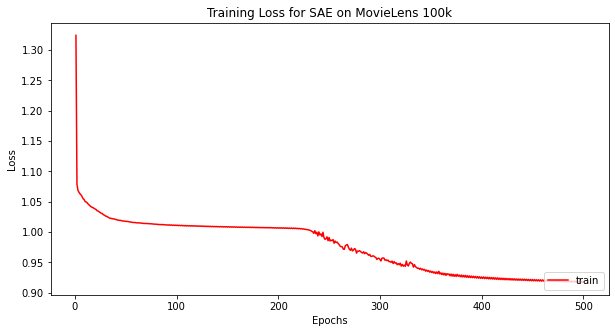

In [ ]:
plt.plot(epoch_num, save_train_loss, 'r', label='train')
plt.title('Training Loss for SAE on MovieLens 100k')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

**Predict the ratings users will give to films they haven't seen yet**

In [ ]:
predict_SAE = np.zeros((nb_users, nb_movies))

for id_user in range(nb_users):
    input = Variable(data_matrix_torch[id_user]).unsqueeze(0)
    predict_SAE[id_user] = model.cpu().prediction(input.cpu())
#We will use predicted value if the entry is 0 in original rating matrix
data_matrix_pred_SAE = np.where(data_matrix == 0, predict_SAE, data_matrix)

#For measuring the performance we have to use the predicted matrix
X_pred = np.zeros((nb_users, nb_movies))
for i in range(predict_SAE.shape[0]):
    for j in range(predict_SAE.shape[1]):
        X_pred[i, j] = predict_SAE[i, j]

**Original rating matrix**

In [ ]:
print("Original Rating Matrix: \n", data_matrix)

Original Rating Matrix: 
 [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


**Predicted rating matrix**

In [ ]:
print("Rating Matrix after Applying Stacked Auto-Encoder: \n", data_matrix_pred_SAE)

Rating Matrix after Applying Stacked Auto-Encoder: 
 [[5.         3.         4.         ... 1.86406207 2.84742737 2.90949202]
 [4.         3.01409936 2.73719668 ... 1.91775894 2.93149614 2.99325252]
 [3.33632708 2.52090168 2.24380255 ... 1.70183408 2.59401321 2.65623903]
 ...
 [5.         3.71686101 3.49542356 ... 2.19614244 3.368783   3.42705584]
 [4.0923028  3.65767598 3.43055582 ... 2.17314816 3.33262539 3.39122295]
 [3.89693069 5.         3.08697438 ... 2.05085158 3.14033365 3.20069647]]


**RMSE of SAE model**

In [ ]:
ind_matrix = np.zeros((nb_users, nb_movies))
ind_matrix = np.where(data_matrix != 0, 1, 0)

x = np.multiply(X_pred, ind_matrix)
RMSE_SAE = np.sqrt(np.mean((x - data_matrix)**2))
print("RMSE of SAE Model is %f." %RMSE_SAE)

RMSE of SAE Model is 0.231201.


**Save a possible top 10 movies selection for all user**

In [ ]:
#Create an indicator matrix to ensure the movie was not rated previously
ind_matrix = np.zeros((nb_users, nb_movies))
ind_matrix = np.where(data_matrix == 0, 1, 0)

#Multiply predicted rating matrix with this indicator matrix to consider
#only the predicted ones
pred = np.multiply(data_matrix_pred_SAE, ind_matrix)

temp = []
top10 = []
index_ranking = []

# create list with top 10 movies of every person
for person in range(nb_users):
    temp = pred[person]
    top_movies = sorted(range(len(temp)), key=lambda k: temp[k])
    top_movies.reverse()
    index_ranking.append(top_movies[:10])

**Show a possible top 10 movies selection for a random user**

In [ ]:
# Return a set of possible top 10 movies for any user
user_id = np.random.randint(1,943)
user_idx = user_id - 1

print(f'Movie Recommendations for User {user_idx}')
print('-'*50)
print('{:<}\t\t{:<40}\t\t{:<70}'.format('Ranking', 'Movie Title', 'Ranking Score'))
print('-'*90)
for ranking, num in enumerate(index_ranking[user_idx]):
    movie_title = movies['Title'][num]
    print('{:<}\t\t{:<40}\t\t{:<70}\n'.
          format(ranking+1, movie_title, data_matrix_pred_SAE[user_idx][num]))

Movie Recommendations for User 726
--------------------------------------------------
Ranking		Movie Title                             		Ranking Score                                                         
------------------------------------------------------------------------------------------
1		Santa with Muscles (1996)               		4.83693265914917                                                      

2		Saint of Fort Washington, The (1993)    		4.697192668914795                                                     

3		Great Day in Harlem, A (1994)           		4.616018772125244                                                     

4		Someone Else's America (1995)           		4.60572624206543                                                      

5		Aiqing wansui (1994)                    		4.589093208312988                                                     

6		Pather Panchali (1955)                  		4.522915363311768                                                     
